In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
import time
from itertools import chain, combinations, permutations
from IPython.display import Image, display
import urllib.request

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.pipeline import Pipeline

# Challenge: Neural network regressor to predict photometric redshifts
In observational astronomy, measuring the redshift of a galaxy tells us how far away it is, and thus provides crucial information about the structure and evolution of the universe.

Traditionally, redshifts are measured using spectroscopy, which provides highly accurate values but is expensive and time-consuming — suitable only for a limited number of objects.

To overcome this, astronomers often use photometric redshifts (photo-z): estimates of a galaxy’s redshift derived from its brightness (magnitude) in a few broad photometric bands (e.g., ugriz, JHK). These estimates are much faster to obtain, but less precise.

Goal: Build a supervised regression model that predicts the redshift of galaxies from their photometric features using a neural network. Use the spectroscopic redshift 'z' as your label for the supervision of the model.

In [4]:
url = 'https://www.researchgate.net/profile/Yuming-Fu/publication/344192975/figure/fig1/AS:993821525565440@1613956924645/Photometric-redshift-obtained-with-XGBoost-regression-model-against-spectral-redshift-of.png'

In [5]:
display(Image(url=url))
## Example figure!!! from Yuming Fu et al 2021 ApJS 254 6 (this is not what you will reproduce, but quite similar)

# A) The data

The data is based on the Sloan Digital Sky Survey (SDSS) DR16. Each row is a galaxy, and it contains 66 features + the spectroscopic redshift which is our label (supervised learning)
The features include:

- u,g,r,i,z: magnitudes of the objects in the SDSS. These represent the fluxes of light measured in logarithmic units, through various bands from the ultraviolet to the infrared
- 'ra' (right ascension) and 'dec' (declination): position of the object in the sky
- expRad: radius of the object
- expRadErr: error in the radius estimate
- 'z': spectroscopic redshift (or true redshift)

Please first download the training set from this link: https://drive.google.com/file/d/1C0cgPM2WkoB7m9eTYNftM3OGUO7Aqaee/view?usp=sharing

In [7]:
training = pd.read_csv('DR16_trainingset.csv')
validation = pd.read_csv('DR16_validationset.csv')
testing = pd.read_csv('DR16_testingset.csv')

In [31]:
training.keys()

Index(['dec', 'decErr', 'dered_g', 'dered_i', 'dered_r', 'dered_u', 'dered_z',
       'deVRad_g', 'deVRad_i', 'deVRad_r', 'deVRad_z', 'deVRadErr_g',
       'deVRadErr_i', 'deVRadErr_r', 'deVRadErr_z', 'expPhi_g', 'expPhi_i',
       'expPhi_r', 'expPhi_u', 'expPhi_z', 'expRad_g', 'expRad_i', 'expRad_r',
       'expRad_z', 'expRadErr_g', 'expRadErr_i', 'expRadErr_r', 'expRadErr_z',
       'extinction_g', 'extinction_i', 'extinction_r', 'extinction_u',
       'extinction_z', 'fiberMag_g', 'fiberMag_i', 'fiberMag_r', 'fiberMag_u',
       'fiberMag_z', 'fiberMagErr_g', 'fiberMagErr_i', 'fiberMagErr_r',
       'fiberMagErr_u', 'fiberMagErr_z', 'modelMag_g', 'modelMag_i',
       'modelMag_r', 'modelMag_u', 'modelMag_z', 'modelMagErr_g',
       'modelMagErr_i', 'modelMagErr_r', 'modelMagErr_u', 'modelMagErr_z',
       'petroRad_r', 'petroRadErr_r', 'psfMag_g', 'psfMag_i', 'psfMag_r',
       'psfMag_u', 'psfMag_z', 'psfMagErr_g', 'psfMagErr_i', 'psfMagErr_r',
       'psfMagErr_u', 'psfMagErr_z'

#### Answer the following questions:

- The data is already split into training, test, and validation sets. What percentage of the total corresponds to training, validation, and test?

- Make a histogram of the total spectroscopic redshift 'z', as well as individual histograms of 'z' for the training, validation, and test sets. Use a log scale on the y-axis. Are these distributions similar? Do you think the splitting into training/validation/test sets was done correctly?

- Generate x_train, y_train, x_test, y_test, x_valid, y_valid. Apply a StandardScaler preprocessing step.

In [ ]:
training.shape, validation.shape, testing.shape 

83445/(83445+17881+17882) # training = 0.7
17881/(83445+17881+17882) # validation = 0.15
17882/(83445+17881+17882) # testing = 0.15 

119208

<Axes: xlabel='z', ylabel='Count'>

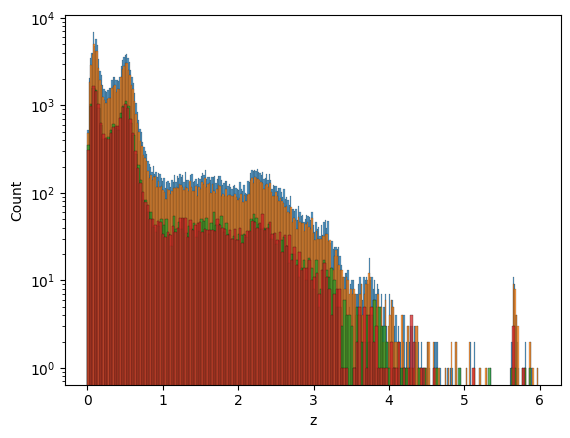

In [45]:
total_df = pd.concat([training, validation, testing], ignore_index=True)

sns.histplot(total_df, x="z", log=True) 
sns.histplot(training, x="z", log=True)
sns.histplot(validation, x="z", log=True)
sns.histplot(testing, x="z", log=True)

# yes done correctly, same distribution 

In [78]:
y_train = training['z']
y_valid = validation['z']
y_test = testing['z']

X_train = training.drop(['z'],axis=1)
X_valid = validation.drop(['z'],axis=1)
X_test = testing.drop(['z'],axis=1)

scaler1 = StandardScaler().fit(X_train)
x_train = scaler1.transform(X_train)
x_test = scaler1.transform(X_test)
x_valid = scaler1.transform(X_valid)

## B) Let's train a neural network!
The following cell provides a baseline neural network architecture. Based on this, try the following modifications:

- Add more layers and/or increase the number of neurons.

- Include additional Dropout layers between Dense layers.

- Remove all Dropout layers.

- Change the learning rate to 0.1.

Observe the effect on the training and validation loss curves for each case.

Additionally, how does the model perform at high redshift values (e.g., z > 3)?

In [79]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(66,)),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1, activation='relu')
    ]
)
model.summary()
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['mae']
    )


start = time.time()

history = model.fit(x_train,y_train,validation_data=(x_valid, y_valid), batch_size=100, epochs=100, verbose = 1)
plt.plot(history.history['loss'],c='r',label='Training')
plt.plot(history.history['val_loss'],c='g',label='Validation')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
plt.show()

print('Testing \n')

y_pred = model.predict(x_test)
plt.scatter(y_test,y_pred,alpha=0.4,marker=r'$\clubsuit$',c='g')
plt.xlabel('$z_{spec}$')
plt.ylabel('$z_{phot}$')
plt.show()

rms = np.sqrt(np.mean((np.array(pd.DataFrame(y_pred)[0]) - y_test)** 2))
print('RMS Testing: ', rms)
print('MSE Testing: ', mean_squared_error(y_pred, y_test))
print('R2 Testing: ', r2_score(y_test, y_pred))

print('Time: ', time.time()- start)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 30)             │         2,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,331 (9.11 KB)

 Trainable params: 2,331 (9.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4526 - mae: 0.4526 - val_loss: 0.2274 - val_mae: 0.2274
Epoch 2/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - loss: 0.2284 - mae: 0.2284 - val_loss: 0.1886 - val_mae: 0.1886
Epoch 3/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - loss: 0.1966 - mae: 0.1966 - val_loss: 0.1745 - val_mae: 0.1745
Epoch 4/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - loss: 0.1816 - mae: 0.1816 - val_loss: 0.1661 - val_mae: 0.1661
Epoch 5/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1712 - mae: 0.1712 - val_loss: 0.1603 - val_mae: 0.1603
Epoch 6/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - loss: 0.1686 - mae: 0.1686 - val_loss: 0.1545 - val_mae: 0.1545
Epoch 7/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - loss: 0.1627 - mae: 0.1627 - val_loss: 0.1504 - val_mae: 0.1504
Epoch 8/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1569 - mae: 0.1569 - val_loss: 0.1462 - val_mae: 0.1462
Epoch 9/100
835/835 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 